[View in Colaboratory](https://colab.research.google.com/github/nisar009/Kaggle_Notebooks/blob/master/Copy_of_Kg_iMat_fashion.ipynb)

**Kaggle iMaterialist Challenge (Fashion) at FGVC5**

Installing Pytorch and Fastai

In [4]:
%%capture
!pip install torch torchvision

In [5]:
%%capture
!pip install fastai

In [6]:
%%capture
!pip install kaggle-cli

**Downloading Kaggle Data Set**

In [7]:
ls

datalab/


In [8]:
!mkdir -p data/fashiondata && cd data/fashiondata && kg download -u nisar009 -p p@55w0rd -c imaterialist-challenge-fashion-2018

downloading https://www.kaggle.com/c/imaterialist-challenge-fashion-2018/download/test.json.zip

test.json.zip 100% |################################| Time: 0:00:00   3.4 MiB/s

downloading https://www.kaggle.com/c/imaterialist-challenge-fashion-2018/download/validation.json.zip

validation.json.zip 100% |##########################| Time: 0:00:00   1.2 MiB/s

downloading https://www.kaggle.com/c/imaterialist-challenge-fashion-2018/download/train.json.zip

train.json.zip 100% |###############################| Time: 0:00:00  27.3 MiB/s

downloading https://www.kaggle.com/c/imaterialist-challenge-fashion-2018/download/sample_submission.csv.zip

sample_submission.csv.zip 100% |####################| Time: 0:00:00   1.0 MiB/s



In [9]:
!cd data/fashiondata && ls

sample_submission.csv.zip  test.json.zip  train.json.zip  validation.json.zip


In [10]:
!cd data/fashiondata && unzip sample_submission.csv.zip && unzip train.json.zip && unzip test.json.zip && unzip validation.json.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  train.json.zip
  inflating: train.json              
Archive:  test.json.zip
  inflating: test.json               
Archive:  validation.json.zip
  inflating: validation.json         


In [11]:
!cd data/fashiondata && ls

sample_submission.csv	   test.json	  train.json	  validation.json
sample_submission.csv.zip  test.json.zip  train.json.zip  validation.json.zip


Create the data set

In [12]:
import pandas as pd
import json

PATH = 'data/fashiondata/'

train_set_file = f'{PATH}train.json'

js = open(train_set_file).read()
train_data_dict = json.loads(js)
train_data_dict['images'][:5]

[{'imageId': '1',
  'url': 'https://contestimg.wish.com/api/webimage/570f35feb2f4b95d223aa9b1-large'},
 {'imageId': '2',
  'url': 'https://contestimg.wish.com/api/webimage/5468f1c0d96b290ff8e5c805-large'},
 {'imageId': '3',
  'url': 'https://contestimg.wish.com/api/webimage/546410237d57f323e72ca414-large'},
 {'imageId': '4',
  'url': 'https://contestimg.wish.com/api/webimage/550b955fdd699c1a0351f84e-large'},
 {'imageId': '5',
  'url': 'https://contestimg.wish.com/api/webimage/54451f33355b4e0fd3028a30-large'}]

Downloading the images with file name imageID

In [13]:
!cd data/fashiondata && mkdir -p images_train && ls

images_train		   test.json	  train.json.zip
sample_submission.csv	   test.json.zip  validation.json
sample_submission.csv.zip  train.json	  validation.json.zip


In [14]:
import urllib.request as url
import concurrent.futures as futures
import os

image_train_dir = os.path.join(PATH, 'images_train')
print(f"Downloading {len(train_data_dict['images'])} Images ...")
with futures.ThreadPoolExecutor(max_workers=30000) as executor:
  os.chdir(image_train_dir)
  for image in train_data_dict['images'][:50000]:
    imageid = image['imageId']
    imageurl = image['url']
    #image_name = os.path.join(image_train_dir, f'{imageid}.jpg')
    image_name = f'{imageid}.jpg'
    executor.submit(url.urlretrieve, f'{imageurl}', image_name)

KeyboardInterrupt: ignored

In [15]:
!cd /content/data/fashiondata/images_train && ls -1| wc -l

58973


In [16]:
os.chdir("/content/")

In [17]:
ls

data/  datalab/


Creating the train.csv which stores < imageid, labels>

In [18]:
print(train_data_dict['annotations'][:10])

[{'labelId': ['95', '66', '137', '70', '20'], 'imageId': '1'}, {'labelId': ['36', '66', '44', '214', '105', '133'], 'imageId': '2'}, {'labelId': ['170', '66', '97', '153', '105', '138'], 'imageId': '3'}, {'labelId': ['18', '66', '44', '153', '164'], 'imageId': '4'}, {'labelId': ['189', '66', '176', '137', '153', '74', '181', '171', '138'], 'imageId': '5'}, {'labelId': ['190', '106', '53', '153', '164', '184'], 'imageId': '6'}, {'labelId': ['114', '222', '113', '176', '214', '87'], 'imageId': '7'}, {'labelId': ['18', '17', '66', '44', '98', '49', '110', '105'], 'imageId': '8'}, {'labelId': ['66', '97', '153', '181', '105', '218'], 'imageId': '9'}, {'labelId': ['91', '66', '59', '49', '151', '105', '225'], 'imageId': '10'}]


In [19]:
annotations = train_data_dict['annotations']
image_train_dict = dict()
image_train_dict['image_id'] = list()
image_train_dict['label_ids'] = list()
for annt in annotations:
  image_train_dict['image_id'].append(annt['imageId'])
  image_train_dict['label_ids'].append(" ".join(annt['labelId']))
  
train_df = pd.DataFrame(image_train_dict)
train_df.tail()

,image_id,label_ids
1014539,1014540,91 66 59 49 105 218
1014540,1014541,66 53 7 155 105 128
1014541,1014542,62 17 222 148 66 98 153 171 184
1014542,1014543,18 66 137 116 105
1014543,1014544,220 222 66 203 186


In [20]:
train_df.set_index('image_id', inplace=True)
train_df.to_csv(os.path.join(PATH, 'train_created.csv'))

We need only the downloaded image's labels in the train.csv

In [21]:
images_downloaded = os.listdir(os.path.join(PATH, 'images_train'))
images_ids_downloaded = [im.split('.')[0] for im in images_downloaded]
len(images_ids_downloaded)

58973

In [22]:
req_train_df = train_df.loc[images_ids_downloaded]
req_train_df.reset_index(inplace=True)
req_train_df['image_id'] = req_train_df['image_id'] + '.jpg'
req_train_df.set_index('image_id', inplace=True)
req_train_df.head()

,label_ids
image_id,
33323.jpg,170 148 66 137 153 171 133
34086.jpg,71 66 153 171 20
35903.jpg,66 44 214 105 87
53881.jpg,122 66 44 214 171 184
22864.jpg,15 66 176 137 214 180 175


In [23]:
req_train_df.sort_index()
#req_train_df.loc['1']
req_train_df.to_csv(os.path.join(PATH, 'train_req.csv'))

In [24]:
!cd data/fashiondata && ls

images_train		   test.json.zip      train_req.csv
sample_submission.csv	   train_created.csv  validation.json
sample_submission.csv.zip  train.json	      validation.json.zip
test.json		   train.json.zip


## **Starting from fastai**

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

fastai Imports

In [4]:
from fastai.imports import *
from fastai.conv_learner import *
from fastai.transforms import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import*

In [5]:
PATH = "data/fashiondata/"
os.makedirs('data/fashiondata/models', exist_ok=True)
os.makedirs('data/fashiondata/tmp', exist_ok=True)
!ls {PATH}

images_train		   test.json.zip      train_req.csv
models			   tmp		      validation.json
sample_submission.csv	   train_created.csv  validation.json.zip
sample_submission.csv.zip  train.json
test.json		   train.json.zip


F1 Score as Metric

In [6]:
from fastai.imports import *
from fastai.transforms import *
from fastai.dataset import *
from sklearn.metrics import fbeta_score
import warnings

def f1(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 1, average='samples')
                    for th in np.arange(start,end,step)])
def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

def opt_th(preds, targs, start=0.17, end=0.24, step=0.01):
    ths = np.arange(start,end,step)
    idx = np.argmax([fbeta_score(targs, (preds>th), 2, average='samples')
                for th in ths])
    return ths[idx]

def get_data(path, tfms,bs,  n, cv_idx):
    val_idxs = get_cv_idxs(n, cv_idx)
    return ImageClassifierData.from_csv(path, 'train-jpg', f'{path}train_v2.csv', bs, tfms,
                                 suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

def get_data_zoom(f_model, path, sz, bs, n, cv_idx):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return get_data(path, tfms, bs, n, cv_idx)

def get_data_pad(f_model, path, sz, bs, n, cv_idx):
    transforms_pt = [RandomRotateZoom(9, 0.18, 0.1), RandomLighting(0.05, 0.1), RandomDihedral()]
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_pt, pad=sz//12)
    return get_data(path, tfms, bs, n, cv_idx)

epoch      trn_loss   val_loss   f1         
    0      0.089256   0.077291   0.401232  



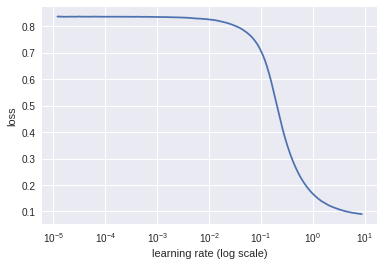

In [7]:
metric = [f1]
sz=64
arch=resnet34
# Lets train a model
def get_data(size):
  tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
  return ImageClassifierData.from_csv(path=PATH,
                                      folder='images_train',
                                      csv_fname=f'{PATH}train_req.csv',
                                     tfms=tfms)
data = get_data(sz)
learn = ConvLearner.pretrained(resnet34, data, precompute=True, metrics=metric)
lrf = learn.lr_find()
learn.sched.plot()


In [0]:
lr = 0.5
learn.precompute=False
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [9]:
# Differential Learning Rates for Different Layer Groups
lrs = np.array([lr/9, lr/3, lr])

NameError: ignored

In [0]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save('resnet34_64')

epoch      trn_loss   val_loss   f1         
    0      0.069734   0.066797   0.475648  
  4%|▍         | 29/738 [00:21<08:37,  1.37it/s, loss=0.0695]

    1      0.066911   0.064526   0.494078  
  8%|▊         | 58/738 [00:40<07:52,  1.44it/s, loss=0.067]

    2      0.066194   0.063848   0.499852  
 10%|█         | 75/738 [00:50<07:29,  1.47it/s, loss=0.0661]

    3      0.065751   0.063064   0.505614  
 12%|█▏        | 85/738 [00:57<07:25,  1.47it/s, loss=0.0644]

    4      0.063936   0.062168   0.510662  
 12%|█▏        | 91/738 [01:00<07:13,  1.49it/s, loss=0.0631]

In [0]:
data = get_data(128)
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)


epoch      trn_loss   val_loss   f1         
    0      0.079864   0.075187   0.419065  
  5%|▍         | 34/738 [00:22<07:53,  1.49it/s, loss=0.0798]

In [0]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save('resnet34_128')

In [0]:
data = get_data(128)
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [0]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save('resnet34_254')